# MissOh DataLoader

### AnotherMissOh Visual Structure
- json_data['file_name'] : 'AnotherMissOh01.mp4'
- json_data['visual_results']
- json_data['visual_results'][0].keys() : dict_keys(['start_time', 'end_time', 'vid', 'image_info'])
- {
'start_time': '00:02:51;16', 
'end_time': '00:02:54;15', 
'vid': 'AnotherMissOh01_001_0078', 
'image_info': ...}
- json_data['visual_results'][0]['image_info']
- [{'frame_id': 'AnotherMissOh01_001_0078_IMAGE_0000004295', 
'place': 'none', 
'persons': [
{'person_id': 'Haeyoung1', 
'person_info': {
'face_rect': {'min_x': 515, 'min_y': 0, 'max_x': 845, 'max_y': 443}, 
'full_rect': {'min_x': 278, 'min_y': 2, 'max_x': 1025, 'max_y': 769}, 
'behavior': 'stand up', 
'predicate': 'none', 
'emotion': 'Neutral', 
'face_rect_score': '0.5', 
'full_rect_score': '0.9'}, 
'related_objects': []}], 
'objects': []}, 
- {'frame_id': 'AnotherMissOh01_001_0078_IMAGE_0000004311', 
'place': '', 
'persons': [{
'person_id':'Haeyoung1',
'person_info': {
'face_rect': {'min_x': 515, 'min_y': 0, 'max_x': 831, 'max_y': 411}, 
'full_rect': {'min_x': 270, 'min_y': 0, 'max_x': 1025, 'max_y': 768}, 
'behavior': 'stand up', 
'predicate': 'none', 
'emotion': 'Neutral', 
'face_rect_score': '0.5', 
'full_rect_score': '0.9'}, 
'related_objects': []}],
'objects': []},]

In [116]:
import sys
sys.path.append("../") # go to parent dir

In [234]:
import os
from torch.utils.data import Dataset, DataLoader
import cv2
import pickle
import numpy as np
import glob
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from PIL import Image
import json
import argparse
import matplotlib.pyplot as plt

from Yolo_v2_pytorch.src.utils import *
from graphviz import Digraph, Graph

In [184]:
def is_not_blank(s):
    return bool(s and s.strip())

In [118]:
MissOh_CLASSES = ['person']
print(MissOh_CLASSES[0])
global colors
colors = pickle.load(open("../Yolo_v2_pytorch/src/pallete", "rb"))
print(colors[0])

person
(39, 129, 113)


In [119]:
def get_args():
    parser = argparse.ArgumentParser(
        "You Only Look Once:Unified, Real-Time Object Detection")
    parser.add_argument("--image_size", type=int,
                        default=448,
                        help="The common width and height for all images")
    parser.add_argument("--batch_size", type=int, default=1,
                        help="The number of images per batch")
    # Training base Setting
    parser.add_argument("--momentum", type=float, default=0.9)
    parser.add_argument("--decay", type=float, default=0.0005)
    parser.add_argument("--dropout", type=float, default=0.5)
    parser.add_argument("--num_epoches", type=int, default=100)
    parser.add_argument("--test_interval", type=int, default=1,
                        help="Number of epoches between testing phases")
    parser.add_argument("--object_scale", type=float, default=1.0)
    parser.add_argument("--noobject_scale", type=float, default=0.5)
    parser.add_argument("--class_scale", type=float, default=1.0)
    parser.add_argument("--coord_scale", type=float, default=5.0)
    parser.add_argument("--reduction", type=int, default=32)
    parser.add_argument("--es_min_delta", type=float, default=0.0,
                        help="Early stopping's parameter:minimum change loss to qualify as an improvement")
    parser.add_argument("--es_patience", type=int, default=0,
                        help="Early stopping's parameter:number of epochs with no improvement after which training will be stopped. Set to 0 to disable this technique.")

    parser.add_argument("--pre_trained_model_type",
                        type=str, choices=["model", "params"],
                        default="model")
    parser.add_argument("--pre_trained_model_path", type=str,
                        default="Yolo_v2_pytorch/trained_models/only_params_trained_yolo_voc") # Pre-training path

    parser.add_argument("--saved_path", type=str,
                        default="./checkpoint") # saved training path
    parser.add_argument("--conf_threshold", type=float, default=0.35)
    parser.add_argument("--nms_threshold", type=float, default=0.5)
    args = parser.parse_args(args=[]) # for jupyter 
    return args

In [120]:
opt = get_args()
print(opt)

Namespace(batch_size=1, class_scale=1.0, conf_threshold=0.35, coord_scale=5.0, decay=0.0005, dropout=0.5, es_min_delta=0.0, es_patience=0, image_size=448, momentum=0.9, nms_threshold=0.5, noobject_scale=0.5, num_epoches=100, object_scale=1.0, pre_trained_model_path='Yolo_v2_pytorch/trained_models/only_params_trained_yolo_voc', pre_trained_model_type='model', reduction=32, saved_path='./checkpoint', test_interval=1)


In [121]:
#splits
num_episode = 1
episode = 1
train = [episode]
val = [5]
test = [6,7]

In [122]:
img_path = '../data/AnotherMissOh/AnotherMissOh_images/'
json_path = '../data/AnotherMissOh/AnotherMissOh_Visual/'

dataset = train

for episode in dataset:
    img_dir = '../data/AnotherMissOh/AnotherMissOh_images/AnotherMissOh{:02}/'.format(episode)
    json_dir = '../data/AnotherMissOh/AnotherMissOh_Visual/AnotherMissOh{:02}_visual.json'.format(episode)

    print('imag_dir:{}'.format(img_dir))
    print('json_dir:{}'.format(json_dir))
    
    with open(json_dir, encoding='utf-8') as json_file:
        json_data = json.load(json_file)

    for i in range(len(json_data['visual_results'])):
        print("***{}th episode***{}th clips***************************************".format(episode, i))
        print("['visual_results'][{}]['start_time']:{}".format(i,json_data['visual_results'][i]['start_time']))
        print("['visual_results'][{}]['end_time']:{}".format(i,json_data['visual_results'][i]['end_time']))
        print("['visual_results'][{}]['vid']:{}".format(i,json_data['visual_results'][i]['vid'].replace('_', '/')))
        img_size = [1024, 768]
        img_scaled_size = [448, 448]
        print("['visual_results'][{}]['img_size']:{}".format(i,img_size))
        print("['visual_results'][{}]['img_scaled_size']:{}".format(i,img_scaled_size))
        print("['visual_results'][{}]['episode']:{}".format(i,episode))
        for j, info in enumerate(json_data['visual_results'][i]['image_info']):
            print("=============={}th frame========================================".format(j))
            print("image_info['frame_id']: {}".format(info['frame_id']).replace('_', '/'))
            print("image_info['place']: {}".format(info['place']))
            for k, person in enumerate(info['persons']):
                print("--------------------{}th person-----------------------------".format(k))
                print("image_info['persons_id']: {}".format(person['person_id']))
                face_bbox = person['person_info']['face_rect']
                if (face_bbox['min_y'] == "" 
                    or face_bbox['max_y'] == "" 
                    or face_bbox['min_x'] == "" 
                    or face_bbox['max_x'] == ""):
                    face_rect = []
                    continue
                else:
                    face_rect = [face_bbox['min_x'], face_bbox['min_y'], face_bbox['max_x'], face_bbox['max_y']]
                print("image_info['persons_info']['face_rect']:{}".format(face_rect))
                full_bbox = person['person_info']['full_rect']
                if (full_bbox['min_y'] == "" 
                    or full_bbox['max_y'] == "" 
                    or full_bbox['min_x'] == "" 
                    or full_bbox['max_x'] == ""):
                    full_rect = []
                    continue
                else:
                    full_rect = [full_bbox['min_x'], full_bbox['min_y'], full_bbox['max_x'], full_bbox['max_y']]
                print("image_info['persons_info']['full_rect']:{}".format(full_rect))
                print("image_info['persons_info']['behavior']:{}".format(person['person_info']['behavior']))
                print("image_info['persons_info']['predicate']:{}".format(person['person_info']['predicate']))
                print("image_info['persons_info']['emotion']:{}".format(person['person_info']['emotion']))
                print("image_info['persons_info']['face_rect_score']:{}".format(person['person_info']['face_rect_score']))
                print("image_info['persons_info']['full_rect_score']:{}".format(person['person_info']['full_rect_score']))

imag_dir:../data/AnotherMissOh/AnotherMissOh_images/AnotherMissOh01/
json_dir:../data/AnotherMissOh/AnotherMissOh_Visual/AnotherMissOh01_visual.json
***1th episode***0th clips***************************************
['visual_results'][0]['start_time']:00:02:51;16
['visual_results'][0]['end_time']:00:02:54;15
['visual_results'][0]['vid']:AnotherMissOh01/001/0078
['visual_results'][0]['img_size']:[1024, 768]
['visual_results'][0]['img_scaled_size']:[448, 448]
['visual_results'][0]['episode']:1
==============0th frame========================================
image/info['frame/id']: AnotherMissOh01/001/0078/IMAGE/0000004295
image_info['place']: none
--------------------0th person-----------------------------
image_info['persons_id']: Haeyoung1
image_info['persons_info']['face_rect']:[515, 0, 845, 443]
image_info['persons_info']['full_rect']:[278, 2, 1025, 769]
image_info['persons_info']['behavior']:stand up
image_info['persons_info']['predicate']:none
image_info['persons_info']['emotion']:Ne

image_info['place']: livingroom
--------------------0th person-----------------------------
image_info['persons_id']: Haeyoung1
image_info['persons_info']['face_rect']:[177, 258, 247, 356]
image_info['persons_info']['full_rect']:[88, 164, 333, 613]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Anger
image_info['persons_info']['face_rect_score']:0.4
image_info['persons_info']['full_rect_score']:0.9
--------------------1th person-----------------------------
image_info['persons_id']: Deogi
image_info['persons_info']['face_rect']:[768, 339, 814, 404]
image_info['persons_info']['full_rect']:[747, 317, 865, 631]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Happiness
image_info['persons_info']['face_rect_score']:0.3
image_info['persons_info']['full_rect_score']:0.9
==============62th frame========================================
image/info

image_info['persons_info']['face_rect_score']:0.7
image_info['persons_info']['full_rect_score']:0.9
==============2th frame========================================
image/info['frame/id']: AnotherMissOh01/001/0116/IMAGE/0000007642
image_info['place']: kitchen
--------------------0th person-----------------------------
image_info['persons_id']: Haeyoung1
image_info['persons_info']['face_rect']:[146, 12, 501, 556]
image_info['persons_info']['full_rect']:[0, 0, 971, 763]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.7
image_info['persons_info']['full_rect_score']:0.9
==============3th frame========================================
image/info['frame/id']: AnotherMissOh01/001/0116/IMAGE/0000007650
image_info['place']: kitchen
--------------------0th person-----------------------------
image_info['persons_id']: Haeyoung1
image_info['persons_info']['face_rect']:[1

image/info['frame/id']: AnotherMissOh01/001/0150/IMAGE/0000009170
image_info['place']: kitchen
--------------------0th person-----------------------------
image_info['persons_id']: Deogi
image_info['persons_info']['face_rect']:[276, 8, 676, 569]
image_info['persons_info']['full_rect']:[52, 3, 872, 769]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Anger
image_info['persons_info']['face_rect_score']:0.6
image_info['persons_info']['full_rect_score']:0.9
==============5th frame========================================
image/info['frame/id']: AnotherMissOh01/001/0150/IMAGE/0000009178
image_info['place']: kitchen
--------------------0th person-----------------------------
image_info['persons_id']: Deogi
image_info['persons_info']['face_rect']:[272, 12, 672, 573]
image_info['persons_info']['full_rect']:[52, 3, 872, 769]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['p

==============3th frame========================================
image/info['frame/id']: AnotherMissOh01/002/0199/IMAGE/0000011814
image_info['place']: room
--------------------0th person-----------------------------
image_info['persons_id']: Deogi
image_info['persons_info']['face_rect']:[466, 226, 536, 337]
image_info['persons_info']['full_rect']:[339, 197, 604, 633]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Anger
image_info['persons_info']['face_rect_score']:0.7
image_info['persons_info']['full_rect_score']:0.9
==============4th frame========================================
image/info['frame/id']: AnotherMissOh01/002/0199/IMAGE/0000011822
image_info['place']: room
==============5th frame========================================
image/info['frame/id']: AnotherMissOh01/002/0199/IMAGE/0000011830
image_info['place']: room
==============6th frame========================================
image/info['frame/id']: A

image_info['persons_info']['full_rect_score']:0.9
==============10th frame========================================
image/info['frame/id']: AnotherMissOh01/003/0233/IMAGE/0000014109
image_info['place']: restaurant
--------------------0th person-----------------------------
image_info['persons_id']: Haeyoung1
image_info['persons_info']['face_rect']:[312, 149, 414, 282]
image_info['persons_info']['full_rect']:[139, 10, 589, 730]
image_info['persons_info']['behavior']:cook
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.8
image_info['persons_info']['full_rect_score']:0.9
==============11th frame========================================
image/info['frame/id']: AnotherMissOh01/003/0233/IMAGE/0000014117
image_info['place']: restaurant
--------------------0th person-----------------------------
image_info['persons_id']: Haeyoung1
image_info['persons_info']['face_rect']:[342, 160, 444, 293]
image_info['persons

image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.7
image_info['persons_info']['full_rect_score']:0.9
==============26th frame========================================
image/info['frame/id']: AnotherMissOh01/004/0267/IMAGE/0000015855
image_info['place']: office
--------------------0th person-----------------------------
image_info['persons_id']: Sukyung
image_info['persons_info']['face_rect']:[202, 141, 249, 212]
image_info['persons_info']['full_rect']:[120, 91, 277, 720]
image_info['persons_info']['behavior']:stand up
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.7
image_info['persons_info']['full_rect_score']:0.9
==============27th frame========================================
image/info['frame/id']: AnotherMissOh01/004/0267/IMAGE/0000015871
image_info['place']: office
==============28th frame=====================

image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Anger
image_info['persons_info']['face_rect_score']:0.9
image_info['persons_info']['full_rect_score']:0.9
==============10th frame========================================
image/info['frame/id']: AnotherMissOh01/004/0299/IMAGE/0000017994
image_info['place']: office
--------------------0th person-----------------------------
image_info['persons_id']: Haeyoung1
image_info['persons_info']['face_rect']:[549, 39, 840, 465]
image_info['persons_info']['full_rect']:[276, 4, 962, 767]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Anger
image_info['persons_info']['face_rect_score']:0.9
image_info['persons_info']['full_rect_score']:0.9
==============11th frame========================================
image/info['frame/id']: AnotherMissOh01/004/0299/IMAGE/0000018002
image_info['place']: office
--------------------0th person-----------------------

image_info['place']: office
==============4th frame========================================
image/info['frame/id']: AnotherMissOh01/005/0331/IMAGE/0000020096
image_info['place']: office
==============5th frame========================================
image/info['frame/id']: AnotherMissOh01/005/0331/IMAGE/0000020104
image_info['place']: office
***1th episode***247th clips***************************************
['visual_results'][247]['start_time']:00:13:24;12
['visual_results'][247]['end_time']:00:13:30;02
['visual_results'][247]['vid']:AnotherMissOh01/005/0332
['visual_results'][247]['img_size']:[1024, 768]
['visual_results'][247]['img_scaled_size']:[448, 448]
['visual_results'][247]['episode']:1
==============0th frame========================================
image/info['frame/id']: AnotherMissOh01/005/0332/IMAGE/0000020116
image_info['place']: office
--------------------0th person-----------------------------
image_info['persons_id']: Haeyoung1
image_info['persons_info']['face_rect']:[

image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Sadness
image_info['persons_info']['face_rect_score']:
image_info['persons_info']['full_rect_score']:0.9
==============16th frame========================================
image/info['frame/id']: AnotherMissOh01/006/0372/IMAGE/0000023222
image_info['place']: office
--------------------0th person-----------------------------
image_info['persons_id']: Gitae
image_info['persons_info']['face_rect']:[723, 69, 806, 190]
image_info['persons_info']['full_rect']:[648, 51, 860, 447]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Anger
image_info['persons_info']['face_rect_score']:0.9
image_info['persons_info']['full_rect_score']:0.9
--------------------1th person-----------------------------
image_info['persons_id']: Sangseok
image_info['persons_info']['face_rect']:[93, 197, 158, 285]
image_info['persons_info']['full_rect']:[46, 178, 239, 547]
i

image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Anger
image_info['persons_info']['face_rect_score']:0.9
image_info['persons_info']['full_rect_score']:0.9
==============5th frame========================================
image/info['frame/id']: AnotherMissOh01/007/0397/IMAGE/0000025452
image_info['place']: studio
--------------------0th person-----------------------------
image_info['persons_id']: Dokyung
image_info['persons_info']['face_rect']:[497, 27, 879, 509]
image_info['persons_info']['full_rect']:[278, 0, 1026, 768]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Anger
image_info['persons_info']['face_rect_score']:0.8
image_info['persons_info']['full_rect_score']:0.8
==============6th frame========================================
image/info['frame/id']: AnotherMissOh01/007/0397/IMAGE/0000025460
image_info['place']: studio
--------------------0th person--------------------------

image_info['persons_info']['behavior']:drink
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Anger
image_info['persons_info']['face_rect_score']:0.7
image_info['persons_info']['full_rect_score']:0.9
==============37th frame========================================
image/info['frame/id']: AnotherMissOh01/007/0405/IMAGE/0000026875
image_info['place']: none
--------------------0th person-----------------------------
image_info['persons_id']: Sangseok
image_info['persons_info']['face_rect']:[654, 236, 728, 349]
image_info['persons_info']['full_rect']:[534, 156, 869, 633]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.6
image_info['persons_info']['full_rect_score']:0.9
--------------------1th person-----------------------------
image_info['persons_id']: Hun
image_info['persons_info']['face_rect']:[326, 140, 391, 233]
image_info['pe

image_info['persons_info']['face_rect']:[364, 139, 620, 493]
image_info['persons_info']['full_rect']:[101, 0, 873, 762]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.9
image_info['persons_info']['full_rect_score']:0.9
==============1th frame========================================
image/info['frame/id']: AnotherMissOh01/007/0427/IMAGE/0000028364
image_info['place']: none
--------------------0th person-----------------------------
image_info['persons_id']: Gitae
image_info['persons_info']['face_rect']:[374, 154, 630, 508]
image_info['persons_info']['full_rect']:[102, 0, 874, 762]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.9
image_info['persons_info']['full_rect_score']:0.9
==============2th frame===========================

image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.3
image_info['persons_info']['full_rect_score']:0.9
--------------------2th person-----------------------------
image_info['persons_id']: Sangseok
image_info['persons_info']['face_rect']:[662, 79, 718, 158]
image_info['persons_info']['full_rect']:[616, 36, 827, 665]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.2
image_info['persons_info']['full_rect_score']:0.9
==============4th frame========================================
image/info['frame/id']: AnotherMissOh01/008/0480/IMAGE/0000031602
image_info['place']: studio
--------------------0th person-----------------------------
image_info['persons_id']: Yijoon
image_info['persons_info']['face_rect']:[524, 396, 565, 446]
image_info['persons_info']['full_rect']:[412, 382, 630, 759]
image_info['persons_info']['behavio

image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.2
image_info['persons_info']['full_rect_score']:0.9
==============6th frame========================================
image/info['frame/id']: AnotherMissOh01/009/0506/IMAGE/0000033907
image_info['place']: road
--------------------0th person-----------------------------
image_info['persons_id']: Heeran
image_info['persons_info']['face_rect']:[284, 184, 391, 339]
image_info['persons_info']['full_rect']:[193, 126, 553, 755]
image_info['persons_info']['behavior']:call
image_info['persons_info']['predicate']:has
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.3
image_info['persons_info']['full_rect_score']:0.9
--------------------1th person-----------------------------
image_info['persons_id']: Haeyoung1
image_info['persons_info']['face_rect']:[653, 174, 755, 315]
image_info['persons_info']['full_rect']:[562, 83, 9

image_info['persons_info']['face_rect_score']:0.8
image_info['persons_info']['full_rect_score']:0.9
==============29th frame========================================
image/info['frame/id']: AnotherMissOh01/010/0519/IMAGE/0000035617
image_info['place']: road
--------------------0th person-----------------------------
image_info['persons_id']: Jinsang
image_info['persons_info']['face_rect']:[217, 216, 338, 399]
image_info['persons_info']['full_rect']:[41, 74, 480, 769]
image_info['persons_info']['behavior']:walk
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.4
image_info['persons_info']['full_rect_score']:0.9
--------------------1th person-----------------------------
image_info['persons_id']: Dokyung
image_info['persons_info']['face_rect']:[605, 164, 736, 333]
image_info['persons_info']['full_rect']:[501, 8, 1002, 769]
image_info['persons_info']['behavior']:walk
image_info['persons_info']['predicate']

image_info['persons_info']['emotion']:Happiness
image_info['persons_info']['face_rect_score']:0.7
image_info['persons_info']['full_rect_score']:0.9
==============1th frame========================================
image/info['frame/id']: AnotherMissOh01/011/0557/IMAGE/0000038099
image_info['place']: road
--------------------0th person-----------------------------
image_info['persons_id']: Deogi
image_info['persons_info']['face_rect']:[278, 164, 409, 347]
image_info['persons_info']['full_rect']:[150, 13, 565, 766]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Happiness
image_info['persons_info']['face_rect_score']:0.7
image_info['persons_info']['full_rect_score']:0.9
==============2th frame========================================
image/info['frame/id']: AnotherMissOh01/011/0557/IMAGE/0000038107
image_info['place']: road
--------------------0th person-----------------------------
image_info['persons_id']: Deogi
im

image_info['persons_info']['face_rect_score']:0.7
image_info['persons_info']['full_rect_score']:1
==============3th frame========================================
image/info['frame/id']: AnotherMissOh01/011/0579/IMAGE/0000040045
image_info['place']: kitchen
--------------------0th person-----------------------------
image_info['persons_id']: Jeongsuk
image_info['persons_info']['face_rect']:[345, 235, 571, 560]
image_info['persons_info']['full_rect']:[93, 17, 817, 769]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.7
image_info['persons_info']['full_rect_score']:1
==============4th frame========================================
image/info['frame/id']: AnotherMissOh01/011/0579/IMAGE/0000040053
image_info['place']: kitchen
--------------------0th person-----------------------------
image_info['persons_id']: Jeongsuk
image_info['persons_info']['face_rect']:[344,

image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.6
image_info['persons_info']['full_rect_score']:
==============10th frame========================================
image/info['frame/id']: AnotherMissOh01/013/0606/IMAGE/0000042163
image_info['place']: studio
--------------------0th person-----------------------------
image_info['persons_id']: Dokyung
image_info['persons_info']['face_rect']:[155, 104, 211, 197]
image_info['persons_info']['full_rect']:[31, 41, 257, 769]
image_info['persons_info']['behavior']:stand up
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Anger
image_info['persons_info']['face_rect_score']:0.6
image_info['persons_info']['full_rect_score']:0.9
--------------------1th person-----------------------------
image_info['persons_id']: Sangseok
image_info['persons_info']['face_rect']:[235, 121, 310, 233]
image_info['persons_info']['full_rect']:[155, 98, 376,

==============0th frame========================================
image/info['frame/id']: AnotherMissOh01/013/0618/IMAGE/0000043767
image_info['place']: studio
==============1th frame========================================
image/info['frame/id']: AnotherMissOh01/013/0618/IMAGE/0000043775
image_info['place']: studio
==============2th frame========================================
image/info['frame/id']: AnotherMissOh01/013/0618/IMAGE/0000043783
image_info['place']: studio
==============3th frame========================================
image/info['frame/id']: AnotherMissOh01/013/0618/IMAGE/0000043791
image_info['place']: studio
***1th episode***526th clips***************************************
['visual_results'][526]['start_time']:00:29:11;24
['visual_results'][526]['end_time']:00:29:15;06
['visual_results'][526]['vid']:AnotherMissOh01/013/0619
['visual_results'][526]['img_size']:[1024, 768]
['visual_results'][526]['img_scaled_size']:[448, 448]
['visual_results'][526]['episode']:1
=======

image_info['persons_id']: Hun
image_info['persons_info']['face_rect']:[918, 187, 955, 242]
image_info['persons_info']['full_rect']:[866, 160, 1014, 453]
image_info['persons_info']['behavior']:stand up
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.3
image_info['persons_info']['full_rect_score']:0.9
--------------------1th person-----------------------------
image_info['persons_id']: Dokyung
image_info['persons_info']['face_rect']:[493, 354, 525, 405]
image_info['persons_info']['full_rect']:[453, 335, 593, 641]
image_info['persons_info']['behavior']:stand up
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.4
image_info['persons_info']['full_rect_score']:0.9
==============9th frame========================================
image/info['frame/id']: AnotherMissOh01/015/0639/IMAGE/0000045149
image_info['place']: none
-----

image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.9
image_info['persons_info']['full_rect_score']:0.9
==============10th frame========================================
image/info['frame/id']: AnotherMissOh01/015/0678/IMAGE/0000047125
image_info['place']: none
==============11th frame========================================
image/info['frame/id']: AnotherMissOh01/015/0678/IMAGE/0000047133
image_info['place']: none
***1th episode***582th clips***************************************
['visual_results'][582]['start_time']:00:31:25;10
['visual_results'][582]['end_time']:00:31:26;03
['visual_results'][582]['vid']:AnotherMissOh01/015/0679
['visual_results'][582]['img_size']:[1024, 768]
['visual_results'][582]['img_scaled_size']:[448, 448]
['visual_results'][582]['episode']:1
==============0th frame========================================
image/info['frame/id']: AnotherMissOh01/015/0679/IMAGE/0000047139
image_in

image_info['persons_info']['full_rect']:[115, 2, 975, 768]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Happiness
image_info['persons_info']['face_rect_score']:0.8
image_info['persons_info']['full_rect_score']:0.9
==============1th frame========================================
image/info['frame/id']: AnotherMissOh01/016/0714/IMAGE/0000050458
image_info['place']: none
--------------------0th person-----------------------------
image_info['persons_id']: Haeyoung1
image_info['persons_info']['face_rect']:[376, 55, 660, 486]
image_info['persons_info']['full_rect']:[116, 3, 977, 769]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Happiness
image_info['persons_info']['face_rect_score']:0.8
image_info['persons_info']['full_rect_score']:0.9
==============2th frame========================================
image/info['frame/id']: AnotherMissOh01/

image_info['persons_info']['emotion']:Happiness
image_info['persons_info']['face_rect_score']:
image_info['persons_info']['full_rect_score']:0.9
==============7th frame========================================
image/info['frame/id']: AnotherMissOh01/018/0747/IMAGE/0000052520
image_info['place']: none
--------------------0th person-----------------------------
image_info['persons_id']: Haeyoung1
image_info['persons_info']['face_rect']:[809, 193, 874, 300]
image_info['persons_info']['full_rect']:[640, 75, 979, 765]
image_info['persons_info']['behavior']:sit down
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Happiness
image_info['persons_info']['face_rect_score']:0.7
image_info['persons_info']['full_rect_score']:0.9
==============8th frame========================================
image/info['frame/id']: AnotherMissOh01/018/0747/IMAGE/0000052528
image_info['place']: none
--------------------0th person-----------------------------
image_info['persons_id']: Hae

image_info['persons_info']['full_rect_score']:0.9
==============3th frame========================================
image/info['frame/id']: AnotherMissOh01/019/0771/IMAGE/0000055346
image_info['place']: none
--------------------0th person-----------------------------
image_info['persons_id']: Dokyung
image_info['persons_info']['face_rect']:[305, 109, 537, 425]
image_info['persons_info']['full_rect']:[141, 8, 727, 765]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.5
image_info['persons_info']['full_rect_score']:0.9
==============4th frame========================================
image/info['frame/id']: AnotherMissOh01/019/0771/IMAGE/0000055354
image_info['place']: none
--------------------0th person-----------------------------
image_info['persons_id']: Jinsang
image_info['persons_info']['face_rect']:[557, 132, 745, 415]
image_info['persons_info']['full_rect'

image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.4
image_info['persons_info']['full_rect_score']:0.6
==============1th frame========================================
image/info['frame/id']: AnotherMissOh01/020/0790/IMAGE/0000057202
image_info['place']: toilet
--------------------0th person-----------------------------
image_info['persons_id']: Dokyung
image_info['persons_info']['face_rect']:[491, 69, 793, 489]
image_info['persons_info']['full_rect']:[426, 0, 1026, 763]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.4
image_info['persons_info']['full_rect_score']:0.6
==============2th frame========================================
image/info['frame/id']: AnotherMissOh01/020/0790/IMAGE/0000057210
image_info['place']: toilet
==============3th frame========================================
image/info['frame/id']: Anoth

image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.9
image_info['persons_info']['full_rect_score']:0.9
***1th episode***720th clips***************************************
['visual_results'][720]['start_time']:00:39:47;05
['visual_results'][720]['end_time']:00:39:50;22
['visual_results'][720]['vid']:AnotherMissOh01/022/0826
['visual_results'][720]['img_size']:[1024, 768]
['visual_results'][720]['img_scaled_size']:[448, 448]
['visual_results'][720]['episode']:1
==============0th frame========================================
image/info['frame/id']: AnotherMissOh01/022/0826/IMAGE/0000059684
image_info['place']: none
--------------------0th person-----------------------------
image_info['persons_id']: Haeyoung1
image_info['persons_info']['face_rect']:[439, 287, 603, 498]
image_info['persons_info']['full_rect']:[325, 90, 748, 757]
image_info['persons_info']['behavio

image_info['place']: none
--------------------0th person-----------------------------
image_info['persons_id']: Deogi
image_info['persons_info']['face_rect']:[486, 59, 741, 465]
image_info['persons_info']['full_rect']:[230, 0, 996, 767]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.8
image_info['persons_info']['full_rect_score']:0.9
==============1th frame========================================
image/info['frame/id']: AnotherMissOh01/023/0856/IMAGE/0000062232
image_info['place']: none
--------------------0th person-----------------------------
image_info['persons_id']: Deogi
image_info['persons_info']['face_rect']:[436, 113, 691, 519]
image_info['persons_info']['full_rect']:[193, 3, 959, 770]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_

image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.9
image_info['persons_info']['full_rect_score']:0.9
==============1th frame========================================
image/info['frame/id']: AnotherMissOh01/025/0896/IMAGE/0000065220
image_info['place']: garden
--------------------0th person-----------------------------
image_info['persons_id']: Hun
image_info['persons_info']['face_rect']:[540, 89, 846, 487]
image_info['persons_info']['full_rect']:[340, 0, 1022, 752]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.9
image_info['persons_info']['full_rect_score']:0.9
==============2th frame========================================
image/info['frame/id']: AnotherMissOh01/025/0896/IMAGE/0000065228
image_info['place']: garden
------------

==============5th frame========================================
image/info['frame/id']: AnotherMissOh01/027/0951/IMAGE/0000068493
image_info['place']: office
--------------------0th person-----------------------------
image_info['persons_id']: Haeyoung1
image_info['persons_info']['face_rect']:[646, 231, 786, 420]
image_info['persons_info']['full_rect']:[368, 41, 869, 703]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.8
image_info['persons_info']['full_rect_score']:0.9
***1th episode***843th clips***************************************
['visual_results'][843]['start_time']:00:45:39;23
['visual_results'][843]['end_time']:00:45:40;17
['visual_results'][843]['vid']:AnotherMissOh01/027/0952
['visual_results'][843]['img_size']:[1024, 768]
['visual_results'][843]['img_scaled_size']:[448, 448]
['visual_results'][843]['episode']:1
==============0th frame==========

--------------------0th person-----------------------------
image_info['persons_id']: Sukyung
image_info['persons_info']['face_rect']:[799, 241, 917, 414]
image_info['persons_info']['full_rect']:[755, 159, 1025, 769]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.5
image_info['persons_info']['full_rect_score']:0.9
--------------------1th person-----------------------------
image_info['persons_id']: Haeyoung1
image_info['persons_info']['face_rect']:[700, 321, 802, 457]
image_info['persons_info']['full_rect']:[619, 193, 855, 769]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.4
image_info['persons_info']['full_rect_score']:0.9
==============2th frame========================================
image/info['frame/id']: AnotherMissOh01

image_info['persons_info']['face_rect']:[632, 134, 842, 444]
image_info['persons_info']['full_rect']:[331, 28, 1025, 769]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Anger
image_info['persons_info']['face_rect_score']:0.9
image_info['persons_info']['full_rect_score']:0.9
==============1th frame========================================
image/info['frame/id']: AnotherMissOh01/028/0992/IMAGE/0000071124
image_info['place']: restaurant
--------------------0th person-----------------------------
image_info['persons_id']: Sukyung
image_info['persons_info']['face_rect']:[629, 150, 840, 461]
image_info['persons_info']['full_rect']:[331, 28, 1026, 770]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Anger
image_info['persons_info']['face_rect_score']:0.9
image_info['persons_info']['full_rect_score']:0.9
==============2th frame===================

image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.9
image_info['persons_info']['full_rect_score']:0.9
==============23th frame========================================
image/info['frame/id']: AnotherMissOh01/029/1025/IMAGE/0000073449
image_info['place']: restaurant
--------------------0th person-----------------------------
image_info['persons_id']: Haeyoung1
image_info['persons_info']['face_rect']:[466, 68, 792, 534]
image_info['persons_info']['full_rect']:[174, 0, 1026, 768]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.9
image_info['persons_info']['full_rect_score']:0.9
==============24th frame========================================
image/info['frame/id']: AnotherMissOh01/029/1025/IMAGE/0000073457
image_info['place']: restaurant
--------------------0th person----------

image/info['frame/id']: AnotherMissOh01/030/1049/IMAGE/0000075753
image_info['place']: none
--------------------0th person-----------------------------
image_info['persons_id']: Sukyung
image_info['persons_info']['face_rect']:[175, 231, 211, 282]
image_info['persons_info']['full_rect']:[113, 207, 253, 665]
image_info['persons_info']['behavior']:stand up
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.5
image_info['persons_info']['full_rect_score']:0.9
==============2th frame========================================
image/info['frame/id']: AnotherMissOh01/030/1049/IMAGE/0000075761
image_info['place']: none
--------------------0th person-----------------------------
image_info['persons_id']: Sukyung
image_info['persons_info']['face_rect']:[178, 234, 214, 285]
image_info['persons_info']['full_rect']:[113, 207, 253, 665]
image_info['persons_info']['behavior']:stand up
image_info['persons_info']['predicate

image_info['persons_id']: Haeyoung1
image_info['persons_info']['face_rect']:[362, 159, 593, 478]
image_info['persons_info']['full_rect']:[69, 0, 798, 757]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.8
image_info['persons_info']['full_rect_score']:0.9
==============1th frame========================================
image/info['frame/id']: AnotherMissOh01/030/1077/IMAGE/0000077880
image_info['place']: none
--------------------0th person-----------------------------
image_info['persons_id']: Haeyoung1
image_info['persons_info']['face_rect']:[352, 180, 583, 500]
image_info['persons_info']['full_rect']:[46, 0, 779, 768]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.8
image_info['persons_info']['full_rect_score']:0.9
***1th episo

['visual_results'][988]['vid']:AnotherMissOh01/031/1100
['visual_results'][988]['img_size']:[1024, 768]
['visual_results'][988]['img_scaled_size']:[448, 448]
['visual_results'][988]['episode']:1
==============0th frame========================================
image/info['frame/id']: AnotherMissOh01/031/1100/IMAGE/0000080077
image_info['place']: cafe
--------------------0th person-----------------------------
image_info['persons_id']: Haeyoung1
image_info['persons_info']['face_rect']:[264, 0, 533, 401]
image_info['persons_info']['full_rect']:[36, 0, 739, 761]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.9
image_info['persons_info']['full_rect_score']:0.9
==============1th frame========================================
image/info['frame/id']: AnotherMissOh01/031/1100/IMAGE/0000080085
image_info['place']: cafe
--------------------0th person-------------------

image/info['frame/id']: AnotherMissOh01/034/1120/IMAGE/0000082914
image_info['place']: park
--------------------0th person-----------------------------
image_info['persons_id']: Hun
image_info['persons_info']['face_rect']:[346, 78, 487, 266]
image_info['persons_info']['full_rect']:[196, 0, 711, 768]
image_info['persons_info']['behavior']:put arms around each other's shoulder
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.2
image_info['persons_info']['full_rect_score']:
==============10th frame========================================
image/info['frame/id']: AnotherMissOh01/034/1120/IMAGE/0000082922
image_info['place']: park
--------------------0th person-----------------------------
image_info['persons_id']: Hun
image_info['persons_info']['face_rect']:[405, 84, 503, 233]
image_info['persons_info']['full_rect']:[260, 0, 767, 768]
image_info['persons_info']['behavior']:put arms around each other's shou

image_info['persons_info']['face_rect_score']:0.9
image_info['persons_info']['full_rect_score']:0.9
==============9th frame========================================
image/info['frame/id']: AnotherMissOh01/035/1140/IMAGE/0000084770
image_info['place']: cafe
--------------------0th person-----------------------------
image_info['persons_id']: Heeran
image_info['persons_info']['face_rect']:[317, 160, 473, 411]
image_info['persons_info']['full_rect']:[169, 17, 655, 755]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:in front of
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.9
image_info['persons_info']['full_rect_score']:0.9
==============10th frame========================================
image/info['frame/id']: AnotherMissOh01/035/1140/IMAGE/0000084778
image_info['place']: cafe
--------------------0th person-----------------------------
image_info['persons_id']: Heeran
image_info['persons_info']['face_rect'

image_info['persons_info']['full_rect']:[254, 65, 612, 760]
image_info['persons_info']['behavior']:stand up
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.7
image_info['persons_info']['full_rect_score']:0.9
==============2th frame========================================
image/info['frame/id']: AnotherMissOh01/036/1181/IMAGE/0000087425
image_info['place']: cafe
--------------------0th person-----------------------------
image_info['persons_id']: Dokyung
image_info['persons_info']['face_rect']:[383, 145, 514, 324]
image_info['persons_info']['full_rect']:[254, 65, 612, 760]
image_info['persons_info']['behavior']:stand up
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.7
image_info['persons_info']['full_rect_score']:0.9
==============3th frame========================================
image/info['frame/id']: AnotherMiss

image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.8
image_info['persons_info']['full_rect_score']:0.9
==============3th frame========================================
image/info['frame/id']: AnotherMissOh01/037/1217/IMAGE/0000089738
image_info['place']: road
--------------------0th person-----------------------------
image_info['persons_id']: Dokyung
image_info['persons_info']['face_rect']:[752, 109, 807, 192]
image_info['persons_info']['full_rect']:[686, 46, 936, 299]
image_info['persons_info']['behavior']:walk
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.8
image_info['persons_info']['full_rect_score']:0.9
==============4th frame========================================
image/info['frame/id']: AnotherMissOh01/037/1217/IMAGE/0000089746
image_info['place']: road
==============5th frame================================

image/info['frame/id']: AnotherMissOh01/038/1252/IMAGE/0000091939
image_info['place']: road
--------------------0th person-----------------------------
image_info['persons_id']: Jinsang
image_info['persons_info']['face_rect']:[237, 207, 554, 599]
image_info['persons_info']['full_rect']:[145, 8, 978, 756]
image_info['persons_info']['behavior']:look for
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.5
image_info['persons_info']['full_rect_score']:0.9
==============1th frame========================================
image/info['frame/id']: AnotherMissOh01/038/1252/IMAGE/0000091947
image_info['place']: road
--------------------0th person-----------------------------
image_info['persons_id']: Jinsang
image_info['persons_info']['face_rect']:[244, 230, 561, 622]
image_info['persons_info']['full_rect']:[145, 8, 978, 756]
image_info['persons_info']['behavior']:look for
image_info['persons_info']['predicate']:


['visual_results'][1168]['episode']:1
==============0th frame========================================
image/info['frame/id']: AnotherMissOh01/039/1280/IMAGE/0000093887
image_info['place']: 
--------------------0th person-----------------------------
image_info['persons_id']: Heeran
image_info['persons_info']['face_rect']:[298, 174, 537, 562]
image_info['persons_info']['full_rect']:[93, 8, 769, 766]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.8
image_info['persons_info']['full_rect_score']:0.9
==============1th frame========================================
image/info['frame/id']: AnotherMissOh01/039/1280/IMAGE/0000093895
image_info['place']: 
--------------------0th person-----------------------------
image_info['persons_id']: Heeran
image_info['persons_info']['face_rect']:[283, 175, 523, 563]
image_info['persons_info']['full_rect']:[93, 8, 769, 766]
ima

image_info['place']: riverside
--------------------0th person-----------------------------
image_info['persons_id']: Jinsang
image_info['persons_info']['face_rect']:[568, 179, 781, 528]
image_info['persons_info']['full_rect']:[230, 0, 897, 768]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Anger
image_info['persons_info']['face_rect_score']:0.7
image_info['persons_info']['full_rect_score']:0.9
--------------------1th person-----------------------------
image_info['persons_id']: Dokyung
image_info['persons_info']['face_rect']:[0, 80, 249, 462]
image_info['persons_info']['full_rect']:[0, 8, 330, 765]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.8
image_info['persons_info']['full_rect_score']:0.9
==============7th frame========================================
image/info['frame/id']

--------------------0th person-----------------------------
image_info['persons_id']: Jinsang
image_info['persons_info']['face_rect']:[505, 135, 742, 518]
image_info['persons_info']['full_rect']:[218, 21, 956, 768]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.3
image_info['persons_info']['full_rect_score']:0.9
==============2th frame========================================
image/info['frame/id']: AnotherMissOh01/042/1316/IMAGE/0000097953
image_info['place']: car
--------------------0th person-----------------------------
image_info['persons_id']: Jinsang
image_info['persons_info']['face_rect']:[504, 144, 741, 527]
image_info['persons_info']['full_rect']:[218, 22, 956, 769]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.3
ima

image_info['place']: road
--------------------0th person-----------------------------
image_info['persons_id']: Dokyung
image_info['persons_info']['face_rect']:[611, 130, 857, 523]
==============8th frame========================================
image/info['frame/id']: AnotherMissOh01/043/1353/IMAGE/0000100320
image_info['place']: road
--------------------0th person-----------------------------
image_info['persons_id']: Dokyung
image_info['persons_info']['face_rect']:[575, 115, 821, 508]
==============9th frame========================================
image/info['frame/id']: AnotherMissOh01/043/1353/IMAGE/0000100328
image_info['place']: road
--------------------0th person-----------------------------
image_info['persons_id']: Dokyung
image_info['persons_info']['face_rect']:[558, 104, 850, 525]
==============10th frame========================================
image/info['frame/id']: AnotherMissOh01/043/1353/IMAGE/0000100336
image_info['place']: road
--------------------0th person----------

In [167]:
class AnotherMissOh(Dataset):
    def __init__(self, dataset, img_path, json_path, display_log=True):
        
        self.display_log = display_log
        self.init_clips(img_path)
        self.load_json(dataset,img_path, json_path)
        
    def init_clips(self, img_path):
        self.cnt_clips = 0
        self.img_path = img_path
        
        self.img_size = (1024, 768)
        self.img_scaled_size = (448, 448)
        
        tform = [
            Resize(self.img_scaled_size), # should match to Yolo_V2
            ToTensor(), 
            #Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # should match to Yolo_V2
        ]
        self.transformations = Compose(tform)
        
        '''
        clips = {
            'episode' : [],
            'clip' : [],
            'start_time' : [],
            'end_time' : [],
            'vid' : [],
            'img_size' : [],
            'img_scaled_size' : [],
            'image_info' : []}
            
        image_info = {
            'frame_id': [],
            'place' : [],
            'persons' : []}
            
        persons = {
            'person_id': [],
            'face_rect' : [],
            'full_rect' : [],
            'behavior' : [],
            'predicate' : [],
            'emotion' : [],
            'face_rect_score' : [],
            'full_rect_score' : []}
        '''
        
    def load_json(self, dataset, img_path, json_path):
        
        self.clips = []
        
        for episode in dataset:
            img_dir = img_path + 'AnotherMissOh{:02}/'.format(episode)
            json_dir = json_path + 'AnotherMissOh{:02}_visual.json'.format(episode)
            if self.display_log:
                print('imag_dir:{}'.format(img_dir))
                print('json_dir:{}'.format(json_dir))

            with open(json_dir, encoding='utf-8') as json_file:
                json_data = json.load(json_file)

            for i in range(len(json_data['visual_results'])):
                clip = {}
                clip['episode'] = []
                clip['clip'] = []
                clip['start_time'] = []
                clip['end_time'] = []
                clip['vid'] = []
                clip['image_info'] = []
                
                if self.display_log:
                    print("***{}th episode***{}th clips***************************************".format(episode, i))
                    print("['visual_results'][{}]['start_time']:{}".format(i,json_data['visual_results'][i]['start_time']))
                    print("['visual_results'][{}]['end_time']:{}".format(i,json_data['visual_results'][i]['end_time']))
                    print("['visual_results'][{}]['vid']:{}".format(i,json_data['visual_results'][i]['vid'].replace('_', '/')))
                    print("['visual_results'][{}]['img_size']:{}".format(i,img_size))
                    print("['visual_results'][{}]['img_scaled_size']:{}".format(i,img_scaled_size))
                    print("['visual_results'][{}]['episode']:{}".format(i,episode))
                
                clip['episode'].append(episode)
                clip['clip'].append(i)
                clip['start_time'].append(json_data['visual_results'][i]['start_time'])
                clip['end_time'].append(json_data['visual_results'][i]['end_time'])
                clip['vid'].append(json_data['visual_results'][i]['vid'].replace('_', '/'))
                
                
                for j, info in enumerate(json_data['visual_results'][i]['image_info']):
                    image_info = {}
                    image_info['frame_id'] = []
                    image_info['place'] = []
                    image_info['persons'] = {}
                    
                    if self.display_log:
                        print("=============={}th frame========================================".format(j))
                        
                    img_file = img_dir + json_data['visual_results'][i]['vid'].replace('_', '/')[-8:] + '/'+ info['frame_id'][-16:] + '.jpg'
                    image_info['frame_id'].append(img_file)
                    image_info['place'].append(info['place'])
                    
                    image_info['persons']['person_id']=[]
                    image_info['persons']['face_rect']=[]
                    image_info['persons']['full_rect']=[]
                    image_info['persons']['behavior']=[]
                    image_info['persons']['predicate']=[]
                    image_info['persons']['emotion']=[]
                    image_info['persons']['face_rect_score']=[]
                    image_info['persons']['full_rect_score']=[]
                    for k, person in enumerate(info['persons']):
                        if self.display_log:
                            print("--------------------{}th person-----------------------------".format(k))
                            
                        image_info['persons']['person_id'].append(person['person_id'])
                        face_bbox = person['person_info']['face_rect']
                        if (face_bbox['min_y'] == "" 
                            or face_bbox['max_y'] == "" 
                            or face_bbox['min_x'] == "" 
                            or face_bbox['max_x'] == ""):
                            face_rect = []
                            continue
                        else:
                            face_rect = [face_bbox['min_x'], face_bbox['min_y'], face_bbox['max_x'], face_bbox['max_y']]
                        image_info['persons']['face_rect'].append(face_rect)
                        full_bbox = person['person_info']['full_rect']
                        if (full_bbox['min_y'] == "" 
                            or full_bbox['max_y'] == "" 
                            or full_bbox['min_x'] == "" 
                            or full_bbox['max_x'] == ""):
                            full_rect = []
                            continue
                        else:
                            full_rect = [full_bbox['min_x'], full_bbox['min_y'], full_bbox['max_x'], full_bbox['max_y']]
                        image_info['persons']['full_rect'].append(full_rect)
                        image_info['persons']['behavior'].append(person['person_info']['behavior'])
                        image_info['persons']['predicate'].append(person['person_info']['predicate'])
                        image_info['persons']['emotion'].append(person['person_info']['emotion'])
                        image_info['persons']['face_rect_score'].append(person['person_info']['face_rect_score'])
                        image_info['persons']['full_rect_score'].append(person['person_info']['full_rect_score'])
                        
                    clip['image_info'].append(image_info)
                self.clips.append(clip)
                    
    def __len__(self):
        return len(self.clips)
                    
    def __getitem__(self, item):
        image_info = self.clips[item]['image_info']
        
        img_list = []
        for it, frame in enumerate(image_info):
            img = Image.open(frame['frame_id'][0]).convert('RGB')
            img = self.transformations(img)
            img_list.append(img)
        
        return img_list, image_info

In [168]:
img_path = '../data/AnotherMissOh/AnotherMissOh_images/'
json_path = '../data/AnotherMissOh/AnotherMissOh_Visual/'
train_set = AnotherMissOh(train, img_path, json_path, False)

In [232]:
def graph(episode, clip, frm, info):
    import string
    strseq = string.ascii_uppercase
    
    # define  graph
    dot = Digraph('G',filename='fdpclust.gv',engine='fdp')
    dot.attr('graph', rotate = '0', dpi='300',rankdir='TB', size='5,5')
    dot.attr('node', height='0.1', fontsize='7')
    dot.attr('edge', fontsize='7')

    place = "{}".format(info['place'][0])
    sound = "{}".format('sound')
    num_of_persons = len(info['persons']['person_id'])
    
    print("place:{}".format(place))
    print("sound:{}".format(sound))
    
    frm_graph = 'episode_{}_clip_{}_frame_{}'.format(episode, clip, frm)
    dot.node(frm_graph, style='filled', color='lightgrey')
    
    dot.node(place, style='filled', color='lightblue')
    dot.node(sound, style='filled', color='lightblue')

    for p in range(num_of_persons):

        person_id = "{}".format(info['persons']['person_id'][p])
        print("person_id:{}".format(person_id))

        behavior = "{}".format(info['persons']['behavior'][p])
        print("behavior:{}".format(behavior))

        predicate = "{}".format(info['persons']['predicate'][p])
        print("predicate:{}".format(predicate))

        emotion = "{}".format(info['persons']['emotion'][p])
        print("emotion:{}".format(emotion))

        if is_not_blank(person_id):
            dot.node(person_id)
        if is_not_blank(behavior):
            dot.node(behavior, style='filled', color='green')
        if is_not_blank(predicate):
            dot.node(predicate, style='filled', color='yellow')
        if is_not_blank(emotion):
            dot.node(emotion, style='filled', color='blue')

        if is_not_blank(person_id) and is_not_blank(behavior):
            dot.edge(person_id, behavior)
        if is_not_blank(person_id) and is_not_blank(predicate):
            dot.edge(person_id, predicate)
        if is_not_blank(person_id) and is_not_blank(emotion):
            dot.edge(person_id, emotion)
            
    # show in image
    dot.format = 'png'
    dot.render('fdpclust.gv', view=True)

    graph = cv2.imread('fdpclust.gv.png')
    graph = cv2.resize(graph, dsize=(0, 0), fx=600.0/graph.shape[0], fy=600.0/graph.shape[0])

    plt.figure(figsize=(8,8))
    plt.imshow(graph)
    plt.show()

----------------------0-th----------------frame
place:kitchen
num_of_persons:2
place:kitchen
sound:sound
person_id:Jeongsuk
behavior:cook
predicate:
emotion:Happiness
person_id:Deogi
behavior:cook
predicate:
emotion:Happiness


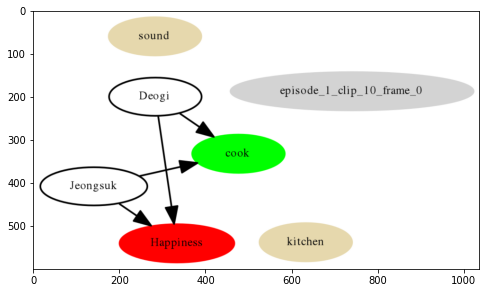

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


person_id:Jeongsuk
face_rect:[632, 93, 679, 157]
full_rect:[571, 41, 748, 382]
behavior:cook
predicate:
emotion:Happiness
person_id:Deogi
face_rect:[306, 377, 399, 466]
full_rect:[255, 343, 456, 654]
behavior:cook
predicate:
emotion:Happiness


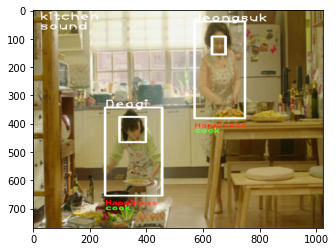

----------------------1-th----------------frame
place:kitchen
num_of_persons:2
place:kitchen
sound:sound
person_id:Jeongsuk
behavior:cook
predicate:
emotion:Happiness
person_id:Deogi
behavior:cook
predicate:
emotion:Happiness


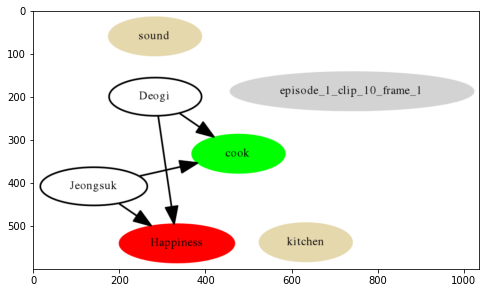

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


person_id:Jeongsuk
face_rect:[649, 106, 699, 183]
full_rect:[587, 41, 764, 382]
behavior:cook
predicate:
emotion:Happiness
person_id:Deogi
face_rect:[306, 392, 399, 481]
full_rect:[255, 343, 456, 654]
behavior:cook
predicate:
emotion:Happiness


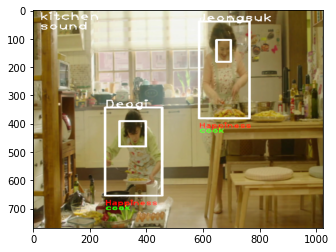

----------------------2-th----------------frame
place:kitchen
num_of_persons:2
place:kitchen
sound:sound
person_id:Jeongsuk
behavior:cook
predicate:
emotion:Happiness
person_id:Deogi
behavior:cook
predicate:
emotion:Happiness


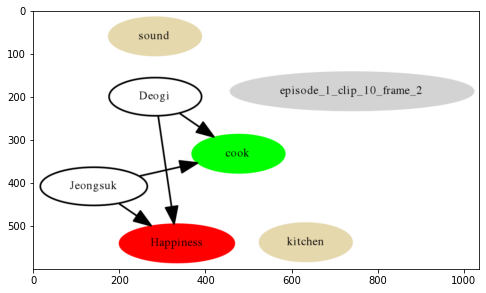

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


person_id:Jeongsuk
face_rect:[667, 104, 737, 179]
full_rect:[621, 35, 798, 376]
behavior:cook
predicate:
emotion:Happiness
person_id:Deogi
face_rect:[314, 378, 407, 467]
full_rect:[264, 343, 465, 654]
behavior:cook
predicate:
emotion:Happiness


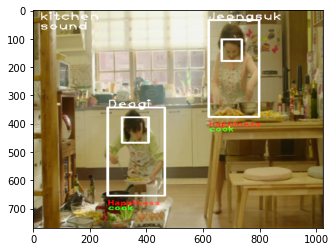

----------------------3-th----------------frame
place:kitchen
num_of_persons:2
place:kitchen
sound:sound
person_id:Jeongsuk
behavior:cook
predicate:
emotion:Happiness
person_id:Deogi
behavior:cook
predicate:
emotion:Happiness


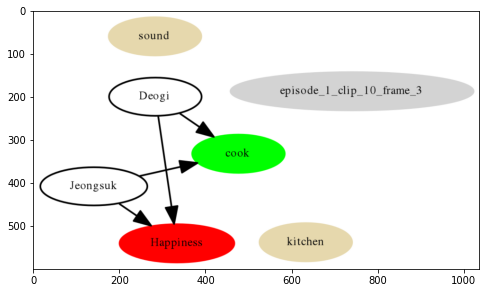

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


person_id:Jeongsuk
face_rect:[668, 104, 738, 181]
full_rect:[638, 31, 815, 372]
behavior:cook
predicate:
emotion:Happiness
person_id:Deogi
face_rect:[314, 397, 407, 486]
full_rect:[264, 343, 465, 654]
behavior:cook
predicate:
emotion:Happiness


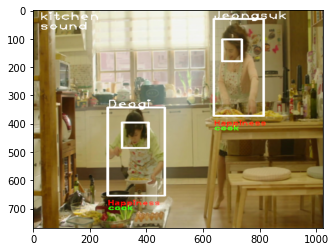

----------------------4-th----------------frame
place:kitchen
num_of_persons:2
place:kitchen
sound:sound
person_id:Jeongsuk
behavior:cook
predicate:
emotion:Happiness
person_id:Deogi
behavior:cook
predicate:
emotion:Happiness


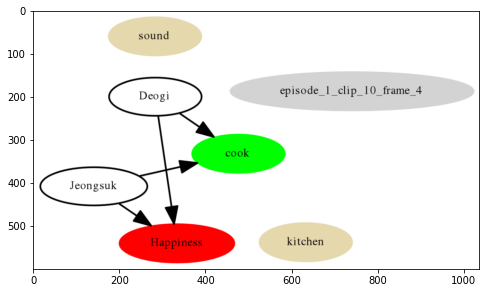

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


person_id:Jeongsuk
face_rect:[668, 104, 738, 181]
full_rect:[638, 31, 815, 372]
behavior:cook
predicate:
emotion:Happiness
person_id:Deogi
face_rect:[314, 397, 407, 486]
full_rect:[264, 343, 465, 654]
behavior:cook
predicate:
emotion:Happiness


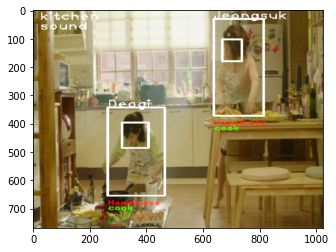

In [261]:
clip = 10
images, info = train_set[clip]

# visualize the images and labels
height, width = (768, 1024)
width_ratio = 448 / width
height_ratio = 448 / height

#print("num_images:{}".format(len(images)))
#print("info:\n{}".format(info))

for frm in range(len(images)):
    image = images[frm].cpu().numpy()

    imageInfo = cv2.cvtColor(np.transpose(image,(1,2,0)), cv2.COLOR_RGB2BGR)
    place = info[frm]['place'][0]
    sound = 'sound'
    print("----------------------{}-th----------------frame".format(frm))
    
    #episode = infos['episode']
    #clip = infos['clip'] 
    #s_time = infos['start_time']
    #e_time = infos['end_time']
    #print("episode:{}, clip:{}, time:{}->{}".format(
    #    episode, clip, s_time, e_time))
    
    num_of_persons = len(info[frm]['persons']['person_id'])
    print("place:{}".format(place))
    print("num_of_persons:{}".format(num_of_persons))
    
    graph(episode, clip, frm, info[frm])

    for p in range(num_of_persons):        
        person_id = info[frm]['persons']['person_id'][p]
        face_rect = info[frm]['persons']['face_rect'][p]
        full_rect = info[frm]['persons']['full_rect'][p]
            
        behavior = info[frm]['persons']['behavior'][p]
        predicate = info[frm]['persons']['predicate'][p]
        emotion = info[frm]['persons']['emotion'][p]
        
        print("person_id:{}".format(person_id))
        print("face_rect:{}".format(face_rect))
        print("full_rect:{}".format(full_rect))
        print("behavior:{}".format(behavior))
        print("predicate:{}".format(predicate))
        print("emotion:{}".format(emotion))

        # face rect
        xmin = int(max(face_rect[0] * width_ratio, 0))
        ymin = int(max(face_rect[1] * height_ratio, 0))
        xmax = int(min((face_rect[2]) * width_ratio, 448))
        ymax = int(min((face_rect[3]) * height_ratio, 448))
        cv2.rectangle(imageInfo, (xmin, ymin), (xmax, ymax), colors[0], 2)
        
        # full rect
        xmin = int(max(full_rect[0] * width_ratio, 0))
        ymin = int(max(full_rect[1] * height_ratio, 0))
        xmax = int(min((full_rect[2]) * width_ratio, 448))
        ymax = int(min((full_rect[3]) * height_ratio, 448))
        cv2.rectangle(imageInfo, (xmin, ymin), (xmax, ymax), colors[2], 2)
        cv2.putText(imageInfo, person_id, (xmin, ymin), 
                    cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 1)
        cv2.putText(imageInfo, emotion, (xmin, ymax+20), 
                    cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 255), 1)
        cv2.putText(imageInfo, behavior, (xmin, ymax+30), 
                    cv2.FONT_HERSHEY_PLAIN, 1, (0, 255, 0), 1)
        cv2.putText(imageInfo, place, (10, 20), 
                    cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 1)
        cv2.putText(imageInfo, sound, (10, 40), 
                    cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 1)
        
    imageInfo = cv2.cvtColor(imageInfo, cv2.COLOR_BGR2RGB)
    imageInfo = cv2.resize(imageInfo,dsize=(1024, 768))
    plt.imshow(imageInfo)
    plt.show()

'kitchen'

In [216]:
PersonCLS = ['Dokyung', 'Haeyoung1', 'Haeyoung2', 'Sukyung', 'Jinsang',
            'Taejin', 'Hun', 'Jiya', 'Kyungsu', 'Deogi',
            'Heeran', 'Jeongsuk', 'Anna', 'Hoijang', 'Soontack',
            'Sungjin', 'Gitae', 'Sangseok', 'Yijoon', 'Seohee', 'Unknown']

P2PRelCLS = ['Friendly', 'Unfriendly', 'Unknown']

ObjectCLS = ['Phone', 'Stick']
P2ORelCLS = ['Holding', 'Wearing', 'Unknown']

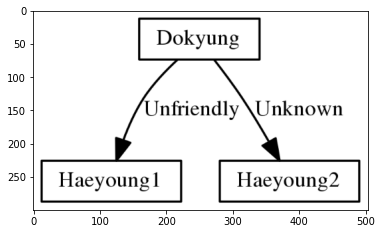

In [218]:
def p2p_relation_digraph(p2p_rel):
    # define direct graph
    dot = Digraph(engine='dot')
    dot.attr('graph', rotate = '0', dpi='300',rankdir='TB', size='4,2')
    dot.attr('node', height='0.1', fontsize='10')
    dot.attr('edge', fontsize='10')

    for n in np.unique(p2p_rel[:, 0:2]): 
        dot.node(PersonCLS[n], shape='rectangle')

    for n in range(len(p2p_rel)): 
        rel = p2p_rel[n]
        dot.edge(PersonCLS[rel[0]], PersonCLS[rel[1]], label=P2PRelCLS[rel[1]])

    dot.format = 'png'
    dot.render('round-table.gv', view=True)

    graph = cv2.imread('round-table.gv.png')
    graph = cv2.resize(graph, dsize=(0, 0), fx=300.0/graph.shape[0], fy=300.0/graph.shape[0])
    plt.imshow(graph)
    plt.show()

p2p_rel = np.stack([[0,1,0], [0,2,1]])
p2p_relation_digraph(p2p_rel)